# TP4: Travail final

## Imports

In [45]:
from collections import defaultdict, Counter
import os
import re
import string
import collections

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import yake

from wordcloud import WordCloud
from IPython.display import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from pprint import pprint

## Exploration du sous-corpus

In [3]:
path = "./corpus/txt/"
output_path = "./corpus/output/"
files = []

files = [f for f in os.listdir(path) if f.endswith('.txt')]

# Imprimer le nombre de fichiers identifiés
print(f"Total files: {len(files)}")
print(files)

Total files: 938
['KB_JB838_1957-04-28_01-00002.txt', 'KB_JB838_1957-03-27_01-00003.txt', 'KB_JB838_1962-05-12_01-00009.txt', 'KB_JB838_1959-10-17_01-00004.txt', 'KB_JB838_1963-09-26_01-00010.txt', 'KB_JB838_1962-07-21_01-00009.txt', 'KB_JB838_1959-10-27_01-00002.txt', 'KB_JB838_1958-01-04_01-00002.txt', 'KB_JB838_1964-09-25_01-00004.txt', 'KB_JB838_1963-01-25_01-00006.txt', 'KB_JB1051_1957-05-31_01-00003.txt', 'KB_JB838_1960-02-25_01-00007.txt', 'KB_JB838_1959-09-12_01-00003.txt', 'KB_JB838_1958-04-20_01-00003.txt', 'KB_JB838_1958-07-08_01-00003.txt', 'KB_JB1051_1957-08-13_01-00004.txt', 'KB_JB838_1958-08-31_01-00003.txt', 'KB_JB838_1964-04-19_01-00002.txt', 'KB_JB838_1958-06-17_01-00003.txt', 'KB_JB1051_1958-06-27_01-00003.txt', 'KB_JB838_1958-03-18_01-00003.txt', 'KB_JB838_1962-12-12_01-00001.txt', 'KB_JB838_1957-07-10_01-00002.txt', 'KB_JB838_1964-09-24_01-00002.txt', 'KB_JB838_1958-09-26_01-00020.txt', 'KB_JB838_1962-04-26_01-00008.txt', 'KB_JB838_1957-03-23_01-00001.txt', 'KB_JB8

In [4]:
# Quelques stats

count_year = defaultdict(int)
count_month = defaultdict(int)
count_decade = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

for f in files:
    if "_" in f and f.endswith("txt") and f != "_README.txt":
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        decade = year[:3] + "0s"
        
        month = int(elems[2].split("-")[1])
        
        count_decade[decade] += 1
        count_newspapers[newspaper] += 1
        count_month[month] += 1
    else:
        print(f"Anomalous file: {f}")

In [5]:
print(f"Il y a {count_newspapers['JB838']} exemplaires du journal Le Soir et {count_newspapers['JB1051']} exemplaires de Le Drapeau rouge")

Il y a 701 exemplaires du journal Le Soir et 237 exemplaires de Le Drapeau rouge


In [6]:
files = [f for f in os.listdir(path) if f.lower().endswith(".txt")]

rows = []
date_re = re.compile(r"(\d{4})-(\d{2})")

for f in files:
    if "_" not in f:
        continue

    elems = f.split("_")
    if len(elems) < 3:
        continue

    journal = elems[1]

    m = date_re.search(f)
    if not m:
        continue

    year = int(m.group(1))
    month = int(m.group(2))

    rows.append({
        "journal": journal,
        "year": year,
        "month": month,
        "year_month": f"{year}-{month:02d}"
    })

df = pd.DataFrame(rows)

print(df.head())
print(df["journal"].value_counts())


  journal  year  month year_month
0   JB838  1957      4    1957-04
1   JB838  1957      3    1957-03
2   JB838  1962      5    1962-05
3   JB838  1959     10    1959-10
4   JB838  1963      9    1963-09
JB838     701
JB1051    237
Name: journal, dtype: int64


In [7]:
year_counts = (
    df.groupby(["year", "journal"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

print(year_counts)


journal  JB1051  JB838
year                  
1957         50    124
1958         54    118
1959         41     85
1960         62     92
1961         30     58
1962          0     59
1963          0     76
1964          0     89


<Figure size 1200x500 with 0 Axes>

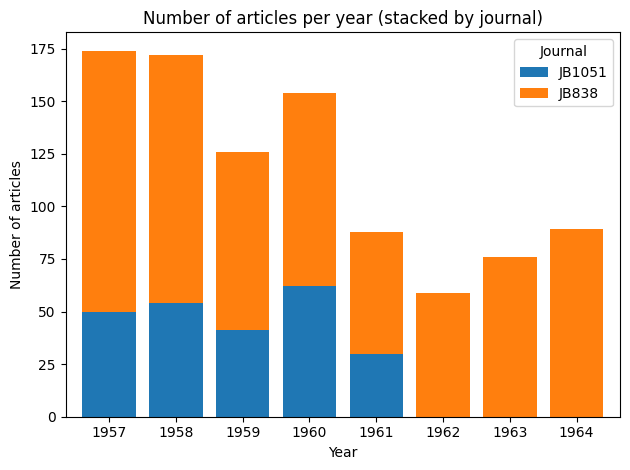

In [8]:
plt.figure(figsize=(12, 5))

year_counts.plot(
    kind="bar",
    stacked=True,
    width=0.8
)

plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of articles per year (stacked by journal)")
plt.xticks(rotation=0)

plt.legend(title="Journal")
plt.tight_layout()
plt.show()


In [9]:
counts = (
    df.groupby(["journal", "year", "month", "year_month"])
      .size()
      .reset_index(name="n_articles")
      .sort_values(["year", "month"])
)

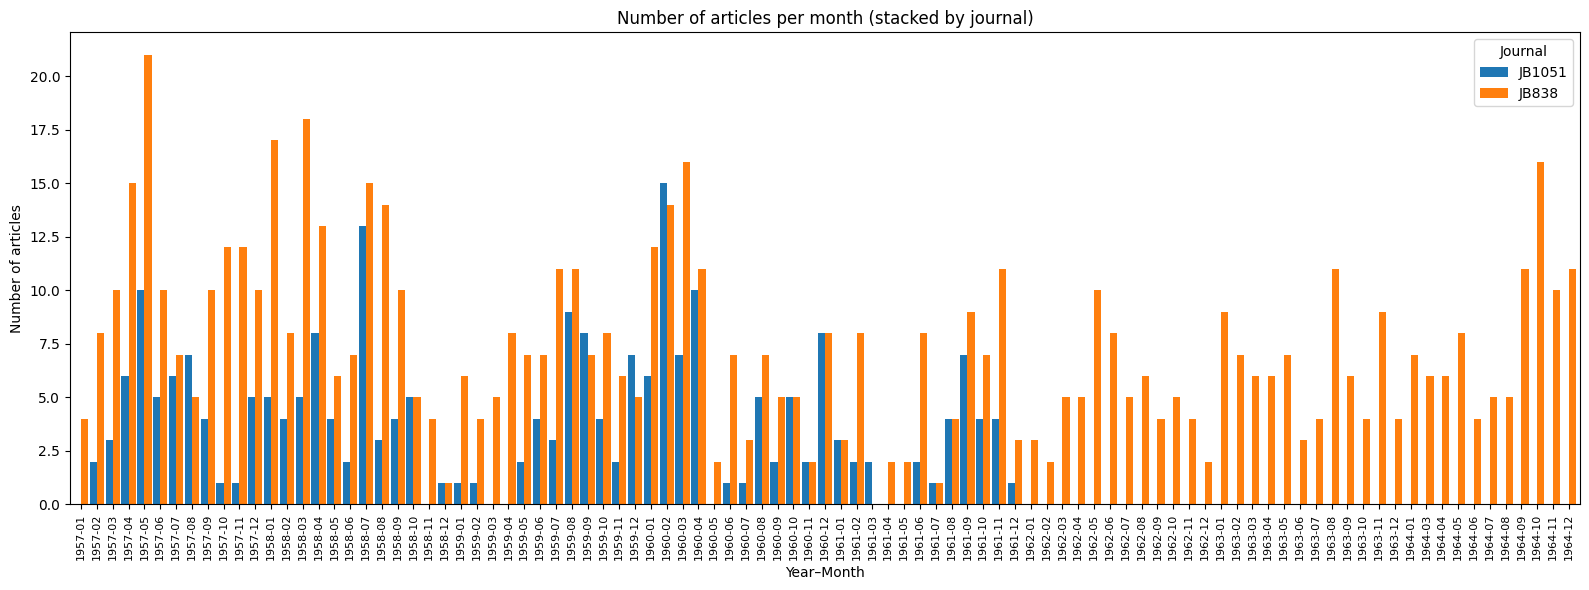

In [10]:
df["year_month"] = pd.to_datetime(df["year_month"], format="%Y-%m")
df = df.sort_values("year_month")
df["year_month_str"] = df["year_month"].dt.strftime("%Y-%m")

ym_counts = (
    df.groupby(["year_month_str", "journal"])
      .size()
      .unstack(fill_value=0)
)

# Plot stacked bars
ax = ym_counts.plot(kind="bar", stacked=False, figsize=(16, 6), width=0.9)

ax.set_xlabel("Year–Month")
ax.set_ylabel("Number of articles")
ax.set_title("Number of articles per month (stacked by journal)")

plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Journal")
plt.tight_layout()
plt.show()


## Analyse du sous-corpus

### Analyse de vocabulaire du contenu des articles

In [11]:
all_path = "./corpus/output/all.txt"

all_list = []

with open(all_path, "w", encoding="utf-8") as output_file:
    for file in os.listdir(path):
        if file.endswith(".txt"):
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                content = f.read()
                all_list.append(content)
                output_file.write(content + "\n")

In [12]:
all_path_jb1051 = "./corpus/output/all_jb1051.txt"

all_list_jb1051 = []

with open(all_path_jb1051, "w", encoding="utf-8") as output_file:
    for file in os.listdir(path):
        if file.endswith(".txt") and file.split("_")[1]=="JB1051":
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                content = f.read()
                all_list_jb1051.append(content)
                output_file.write(content + "\n")

In [13]:
all_path_jb838 = "./corpus/output/all_jb838.txt"

all_list_jb838 = []

with open(all_path_jb838, "w", encoding="utf-8") as output_file:
    for file in os.listdir(path):
        if file.endswith(".txt") and file.split("_")[1]=="JB838":
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                content = f.read()
                all_list_jb838.append(content)
                output_file.write(content + "\n")

In [13]:
# Word Count
!wc ./corpus/output/all.txt

# 938 lines
# 5721789 words
# 35844297 bytes

!wc ./corpus/output/all_jb1051.txt

# 938 lines
# 5721789 words
# 35844297 bytes

     938  5721789 35844297 ./corpus/output/all.txt
    237 1318317 8037670 ./corpus/output/all_jb1051.txt


In [14]:
# Getting the content
text_all = []

with open(all_path, 'r', encoding='utf-8') as f:
    text_all = f.read()

In [15]:
# Tokenization in file
words = nltk.wordpunct_tokenize(text_all)
voc = set(words)
print(f"{len(words)} words found in file ({len(voc)} different word forms)")


7569835 words found in file (299943 different word forms)


In [16]:
words[:20]

['La',
 'Comédie',
 '-',
 'Française',
 'au',
 'théâtre',
 'du',
 'Parc',
 '«',
 'La',
 'seconde',
 'Surprise',
 'de',
 'l',
 '’',
 'Amour',
 '»',
 'et',
 '«',
 'Crispin']

In [17]:
# Getting Le Drapeau Rouge Content
text_all_jb1051 = []

with open(all_path_jb1051, 'r', encoding='utf-8') as f:
    text_all_jb1051 = f.read()

words_jb1051 = nltk.wordpunct_tokenize(text_all_jb1051)
voc_jb1051 = set(words_jb1051)
print(f"{len(words_jb1051)} words found in file ({len(voc_jb1051)} different word forms)")

words_jb1051[:20]

1802120 words found in file (143540 different word forms)


['•^',
 'wsïggi',
 '■',
 'Ï',
 ">-'",
 'MEkstt',
 '*;',
 '■',
 "'",
 'ffil',
 'tiola',
 't',
 'jeunesse',
 '.',
 'les',
 'limites',
 'éalisme',
 'social',
 ',',
 'quand']

In [18]:
# Listing stopwords
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem"]

new_sw = ["Brux", "ecrire","écr", "ecr","brux", "BRUX","bruxelles", "Là","Av", "AV",
       "vend", "prix", "rue", "bon", "Ch", "CH", "ST", "Chff",
       "Tél", "tél", "très", "ans", "PL", "pl", "St",
       "téléph","gar","app", "trav", "ch", "CH", "Ch","pr", "Si", "si", "SI",
       "maison", "ag", "st", "fr", "louer", "conf", "garage", "jard", "vendre", "adr", "chf", "comment",
       "villa", "bel", "av", "km", "AV", "Av", "do", "ét", "avenue", "gr", "inst", "cond",
       "jardin", "rez", "ec", "él", "tél", "moderne", "petite", "belle", "mod", "où",
       "géomètre", "chauf", "télé", "chauff", "cave", "agence", "ii", "appart", "bd", "xl", "télép", "têl", "br",
       "tr", "studio", "leç", "chaussée", "bur", "appartem", "caves", "adrcs", "faç",
       "place", "cherche", "sal", "bain", "référ", "etc", "prés", "ds", "lo", "téléphone", "réf", "meub", "concierge",
       "comm", "dcm", "louise", "ot", "jo", "francs", "lr", "jne", "ouvr", "aven", "cuisine",
       "no", "cyl", "alors", "rr", "sér", "références", "ts", "ad", "référenc", "tt",
       "lcr", "mol", "dlt", "ll", "nf", "pers", "leurs", "vers", "quelques", "grand", "peu", "grande",
       "très", "toute", "soir", "hier"
       ]
sw.extend(new_sw)
sw = set(sw)

In [19]:
def add_sw(sw_set, new_sw_list):
    sw_set.update(set(new_sw_list))
    return sw_set

### Calcul de la taille du vocabulaire

In [20]:
def clean_text(input_file):
    cleaned_lines = []
    with open(input_file,'r', encoding='utf-8') as f:
        for line in f:
            words = nltk.wordpunct_tokenize(line)
            kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
            cleaned_lines.append(" ".join(kept))
    return cleaned_lines

In [21]:
def write_text(text, output_file):
    with open(output_file, "w", encoding="utf-8") as out:
        for line in text:
            out.write(line + "\n")

    return f"The output has been written in {output_file}!"

In [22]:
# Cleaning
all_clean_path = "./corpus/output/all_clean.txt"

all_clean = clean_text(all_path)

write_text(all_clean,all_clean_path)

'The output has been written in ./corpus/output/all_clean.txt!'

In [23]:
# Cleaning DR
all_clean_path_jb1051 = "./corpus/output/all_clean_jb1051.txt"

all_clean_jb1051 = clean_text(all_path_jb1051)

write_text(all_clean_jb1051,all_clean_path_jb1051)

'The output has been written in ./corpus/output/all_clean_jb1051.txt!'

In [24]:
# all
text_clean = []

with open(all_clean_path, 'r', encoding='utf-8') as f:
    text_clean = f.read()

words_kept = nltk.wordpunct_tokenize(text_clean)
voc_kept = set(words_kept)

print(f"{len(words_kept)} words kept ({len(voc_kept)} different word forms)")

2747937 words kept (241010 different word forms)


In [25]:
# dr
text_clean_jb1051 = []

with open(all_clean_path_jb1051, 'r', encoding='utf-8') as f:
    text_clean_jb1051 = f.read()

words_kept_jb1051 = nltk.wordpunct_tokenize(text_clean_jb1051)
voc_kept_jb1051 = set(words_kept_jb1051)

print(f"{len(words_kept_jb1051)} words kept ({len(voc_kept_jb1051)} different word forms)")

642513 words kept (117299 different word forms)


In [26]:
# Récupération des mots les plus fréquents
fdist = nltk.FreqDist(words_kept)
fdist.most_common(20)

[('pays', 7217),
 ('président', 6485),
 ('ministre', 6249),
 ('gouvernement', 5958),
 ('général', 4783),
 ('cours', 4296),
 ('etats', 4296),
 ('politique', 4096),
 ('temps', 4035),
 ('premier', 4003),
 ('part', 3880),
 ('unis', 3768),
 ('france', 3683),
 ('avant', 3484),
 ('belgique', 3477),
 ('guerre', 3449),
 ('conseil', 3444),
 ('monde', 3422),
 ('parti', 3390),
 ('heures', 3243)]

In [27]:
# Récupération des mots les plus fréquents
# dr
fdist_dr = nltk.FreqDist(words_kept_jb1051)
fdist_dr.most_common(20)

[('pays', 1802),
 ('ment', 1735),
 ('parti', 1674),
 ('gouvernement', 1500),
 ('ministre', 1366),
 ('con', 1337),
 ('tion', 1322),
 ('président', 1212),
 ('politique', 1023),
 ('etats', 1013),
 ('général', 889),
 ('pro', 884),
 ('soviétique', 864),
 ('com', 863),
 ('guerre', 859),
 ('unis', 848),
 ('cours', 846),
 ('premier', 839),
 ('monde', 805),
 ('paix', 800)]

<AxesSubplot: xlabel='Samples', ylabel='Cumulative Counts'>

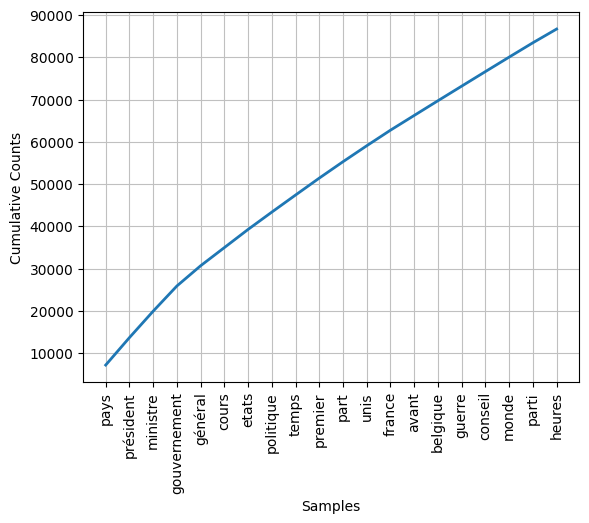

In [28]:
# Plot: les n mots les plus fréquents
n = 20
fdist.plot(n, cumulative=True)

In [29]:
print(fdist.get("bombe"))
print(fdist.get("atomique"))
print(fdist.get("arme"))
print(fdist.get("nucléaire"))


1774
2163
436
1026


In [30]:
print(fdist_dr.get("bombe"))
print(fdist_dr.get("atomique"))
print(fdist_dr.get("arme"))
print(fdist_dr.get("nucléaire"))

413
520
103
163


In [31]:
fdist.hapaxes()[:30]

['nviefniont',
 'ahmam',
 'épouseront',
 'perdriere',
 'quotidieh',
 'embarrassantes',
 'souriez',
 'teune',
 'transvalienne',
 'complimenteur',
 'kaekebroeck',
 'carne',
 'gaudeau',
 'labru',
 'tacteur',
 'impertinences',
 'ganeau',
 'éfimser',
 'friponnerie',
 'vitray',
 'baconnet',
 'samie',
 'grellier',
 'galabru',
 'respens',
 'bellin',
 'vintimilles',
 'evees',
 'phonocardiographlc',
 'gnostic']

In [32]:
# Identification des mots les plus longs
n = 30
sorted(voc, key=len, reverse=True)[:n]

['Îîîïîîîîîîïrîîtîîîîiîïrîiîïîtîîîîtîîîïtsîîïïîïîsîîirxtîisîîîtstsîîîiîîîîîîîsîtîïïtïîîîtjîîiîîîjju',
 'iiitttiiiitittttstxiitizsiîiKiiîiiiitîitiittiittttitttttstiXtttttiîtstiiîUiiainutiütiituu',
 'dlittitîîiiutiiiîiiîîiiiiiititiiiiiuiiliiXiiîiyiiiitttiiztiititïiiîiiittînîiitnxîiiimuii',
 'îîîîMsîtrîiîSîKîjHîîîîttîiSîîjîSîjîaîîHttîîJîîJtttnjttnttîJîîîtainJîtttsiîsiRtasiiiii',
 'tmDœœtœœttætttmBttmmmummHamîJumumtttmjmircttmmmmœmœtrcHafmBmmmummœaœœmtutmHmîJtmmumu',
 'ïittttttittttttiiitttiitittixttttittiiiinttittitmiiittttitttttttuitMtmtttmttnuœitêi',
 'iütîîtJtitîîJttîtinîtittiîmtttîîîttnîttHttiJîJtîttJîtttiîititiîtjntîtjmtîtimtimum',
 'txtitttxnittttttnKttttttittitttmtttxtxiintuiittttnimtitttxtximtttxtttittittm',
 'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiniiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii',
 'tîJîjtJiîtîJîîtJtîttitKJùijnjiatsttîîitîîjmtKîtîJtttînîttmtKîîïsîrtîjtttttn',
 'wtttttititttiimnmttttmwttttfflttmtffltmfflttfflnffltKfflttmtttfflmfflmttmi',
 'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii

### Extraction de mots clés

In [33]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [34]:
keywords_clean = kw_extractor.extract_keywords(text_clean)


In [35]:
keywords_clean_dr = kw_extractor.extract_keywords(text_clean_jb1051)

In [36]:
print(keywords_clean)

[('ministre affaires étrangères', 3.565167386797247e-10), ('président etats unis', 5.293301739557732e-10), ('etats unis bretagne', 1.0689895492374064e-09), ('ministre affaires économiques', 1.1486034813493644e-09), ('gouvernement etats unis', 1.5829084717599172e-09), ('cours conférence presse', 1.6627543749984313e-09), ('voir suite page', 1.6978483787542833e-09), ('président conseil soviétique', 2.0474118872044927e-09), ('ministre défense nationale', 2.285913151325443e-09), ('secrétaire etat américain', 2.9266805616523955e-09), ('ministre travaux publics', 2.9609541949344174e-09), ('etats unis pays', 3.0448839311777272e-09), ('bretagne etats unis', 3.2506008742117045e-09), ('ambassadeur etats unis', 3.3353378857357554e-09), ('etats unis france', 3.34713291026103e-09), ('etats unis président', 3.649592252010857e-09), ('vice président conseil', 3.7342552495655e-09), ('parti communiste belgique', 3.741778596011597e-09), ('bombe atomique française', 3.750173837304483e-09), ('chef gouvernem

In [37]:
print(keywords_clean_dr)

[('parti communiste belgique', 1.1218276809896495e-08), ('ministre affaires étrangères', 2.051758564062347e-08), ('suite page col', 2.7701157209225544e-08), ('parti communiste union', 2.791800589852745e-08), ('etats unis bretagne', 3.245999526749079e-08), ('politique parti communiste', 3.377407614154863e-08), ('comité central parti', 3.4041362928676994e-08), ('président etats unis', 3.5829377846085713e-08), ('parti communiste français', 4.3549562166316715e-08), ('communiste union soviétique', 4.3596800724738435e-08), ('quotidien parti communiste', 4.42438880198437e-08), ('pays pays pays', 4.490435920407052e-08), ('bombe atomique française', 4.826856161734824e-08), ('parti com muniste', 4.870789684972475e-08), ('président conseil soviétique', 4.87138692379759e-08), ('central parti communiste', 5.184137852507014e-08), ('cours conférence presse', 5.6339386353893816e-08), ('bureau politique parti', 6.82006818987173e-08), ('partis communistes ouvriers', 7.123911798093376e-08), ('congrès par

In [38]:
# Garder les bigrammes du fichier intégré
kept = []
for kw, score in keywords_clean:
    words = kw.split()
    if len(words) >= 2:
        kept.append(kw)
print(f"{all_clean_path} mentions these keywords:")
for n in kept:
    print(n)

./corpus/output/all_clean.txt mentions these keywords:
ministre affaires étrangères
président etats unis
etats unis bretagne
ministre affaires économiques
gouvernement etats unis
cours conférence presse
voir suite page
président conseil soviétique
ministre défense nationale
secrétaire etat américain
ministre travaux publics
etats unis pays
bretagne etats unis
ambassadeur etats unis
etats unis france
etats unis président
vice président conseil
parti communiste belgique
bombe atomique française
chef gouvernement soviétique
président conseil ministres
tient lieu part
conférence ministres affaires
ministre ministre affaires
etats unis union
ministre congo belge
etats unis
atomique etats unis
soviétique etats unis
cours dernières années
france etats unis
ministre santé publique
déclaré etats unis
pays pays pays
avis tient lieu
ministre soviétique affaires
pays marché commun
nucléaires etats unis
ancien président conseil
guerre etats unis
ministre instruction publique
etats unis gouvernement

In [39]:
for n in kept: 
    if "bombe" in n or "atomique" in n or "nucléaire" in n or "arme" in n:
     print(n)

bombe atomique française
atomique etats unis
nucléaires etats unis


In [40]:
# Garder les bigrammes du fichier intégré DR
kept = []
for kw, score in keywords_clean_dr:
    words = kw.split()
    if len(words) >= 2:
        kept.append(kw)
print(f"{all_clean_path_jb1051} mentions these keywords:")
for n in kept:
    print(n)

./corpus/output/all_clean_jb1051.txt mentions these keywords:
parti communiste belgique
ministre affaires étrangères
suite page col
parti communiste union
etats unis bretagne
politique parti communiste
comité central parti
président etats unis
parti communiste français
communiste union soviétique
quotidien parti communiste
pays pays pays
bombe atomique française
parti com muniste
président conseil soviétique
central parti communiste
cours conférence presse
bureau politique parti
partis communistes ouvriers
congrès parti communiste
etats unis
explosion bombe atomique
parti socialiste belge
mouvement ouvrier belge
soviétique etats unis
président conseil ministres
etats unis pays
etats unis déclaré
déclaré etats unis
arrêt essais nucléaires
vice président conseil
cours dernières années
drapeau rouge magazine
secrétaire etat américain
membre comité central
gouvernement etats unis
pre mier ministre
etats unis moscou
national parti communiste
parti socialiste ouvrier
drapeau rouge quotidien


### Nuage de mots

In [41]:
## Additional cleaning by adding stopwords
sw = add_sw(sw, ["selon","près", "chez", "chaque", "parmi", "plusieurs", 
                "car", "déjà","con", "mis", "plusieurs", "pourrait", "beaucoup", 
                "ceux", "heures", "trop", "ment", "toujours", "aujourd", "ensuite",
                "également", "ici", "dernier", "effet", "aucun","rien", "puis", "jour",
                "notamment", "enfin", "hui", "donné", "tion", "devant", "actuellement",
                "quand", "elles", "tant", "assez", "semble", "lors", "coté", "ailleurs",
                "reste", "avant", "fois", "quelque", "celui", "celle", "dès", "sait", "laquele",
                "lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche",
                "matin", "grands", "aucune", "temps", "afin", "page", "por", "laquelle",
                "vient", "quel", "plu", "tra", "res", "nou", "tions","com", "las", "tre", "ena",
                "per", "aue", "cent", "ques", "mettre", "certains", "certaines", "pré", "pris", 
                "voir", "vue", "oui"])
text_clean_new = "\n".join(clean_text(all_clean_path))

In [42]:
# Nombre de stopwords
print(len(sw))


424


In [43]:
# Affichage des termes les plus fréquents
frequencies = Counter(text_clean_new.split())
print(frequencies.most_common(10))

[('pays', 7217), ('président', 6485), ('ministre', 6249), ('gouvernement', 5958), ('général', 4783), ('cours', 4296), ('etats', 4296), ('politique', 4096), ('premier', 4003), ('part', 3880)]


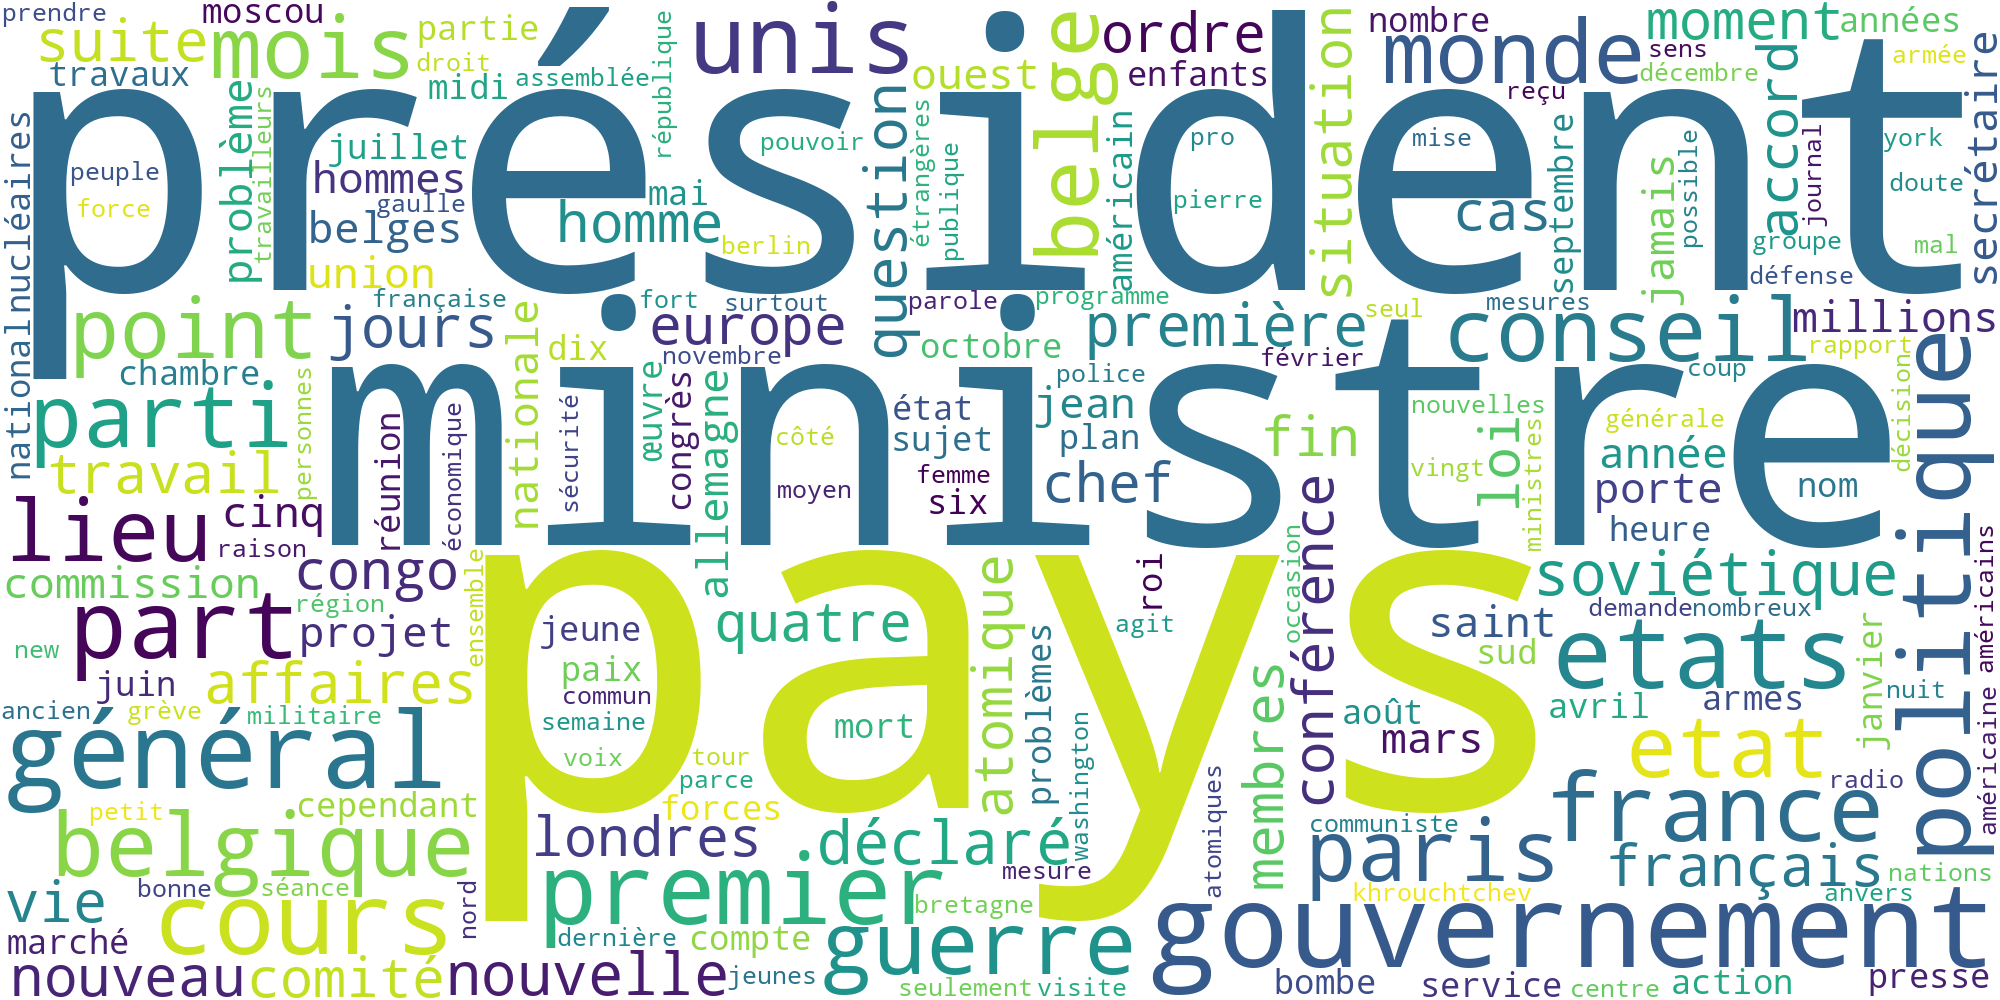

In [44]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(output_path, f"wordcloud_all.png"))
Image(filename=os.path.join(output_path, f"wordcloud_all.png"))

In [45]:
#DR
text_clean_jb1051_new = "\n".join(clean_text(all_clean_path_jb1051))

In [46]:
# Affichage des termes les plus fréquents DR
frequencies_dr = Counter(text_clean_jb1051_new.split())
print(frequencies_dr.most_common(10))

[('pays', 1802), ('parti', 1674), ('gouvernement', 1500), ('ministre', 1366), ('président', 1212), ('politique', 1023), ('etats', 1013), ('général', 889), ('pro', 884), ('soviétique', 864)]


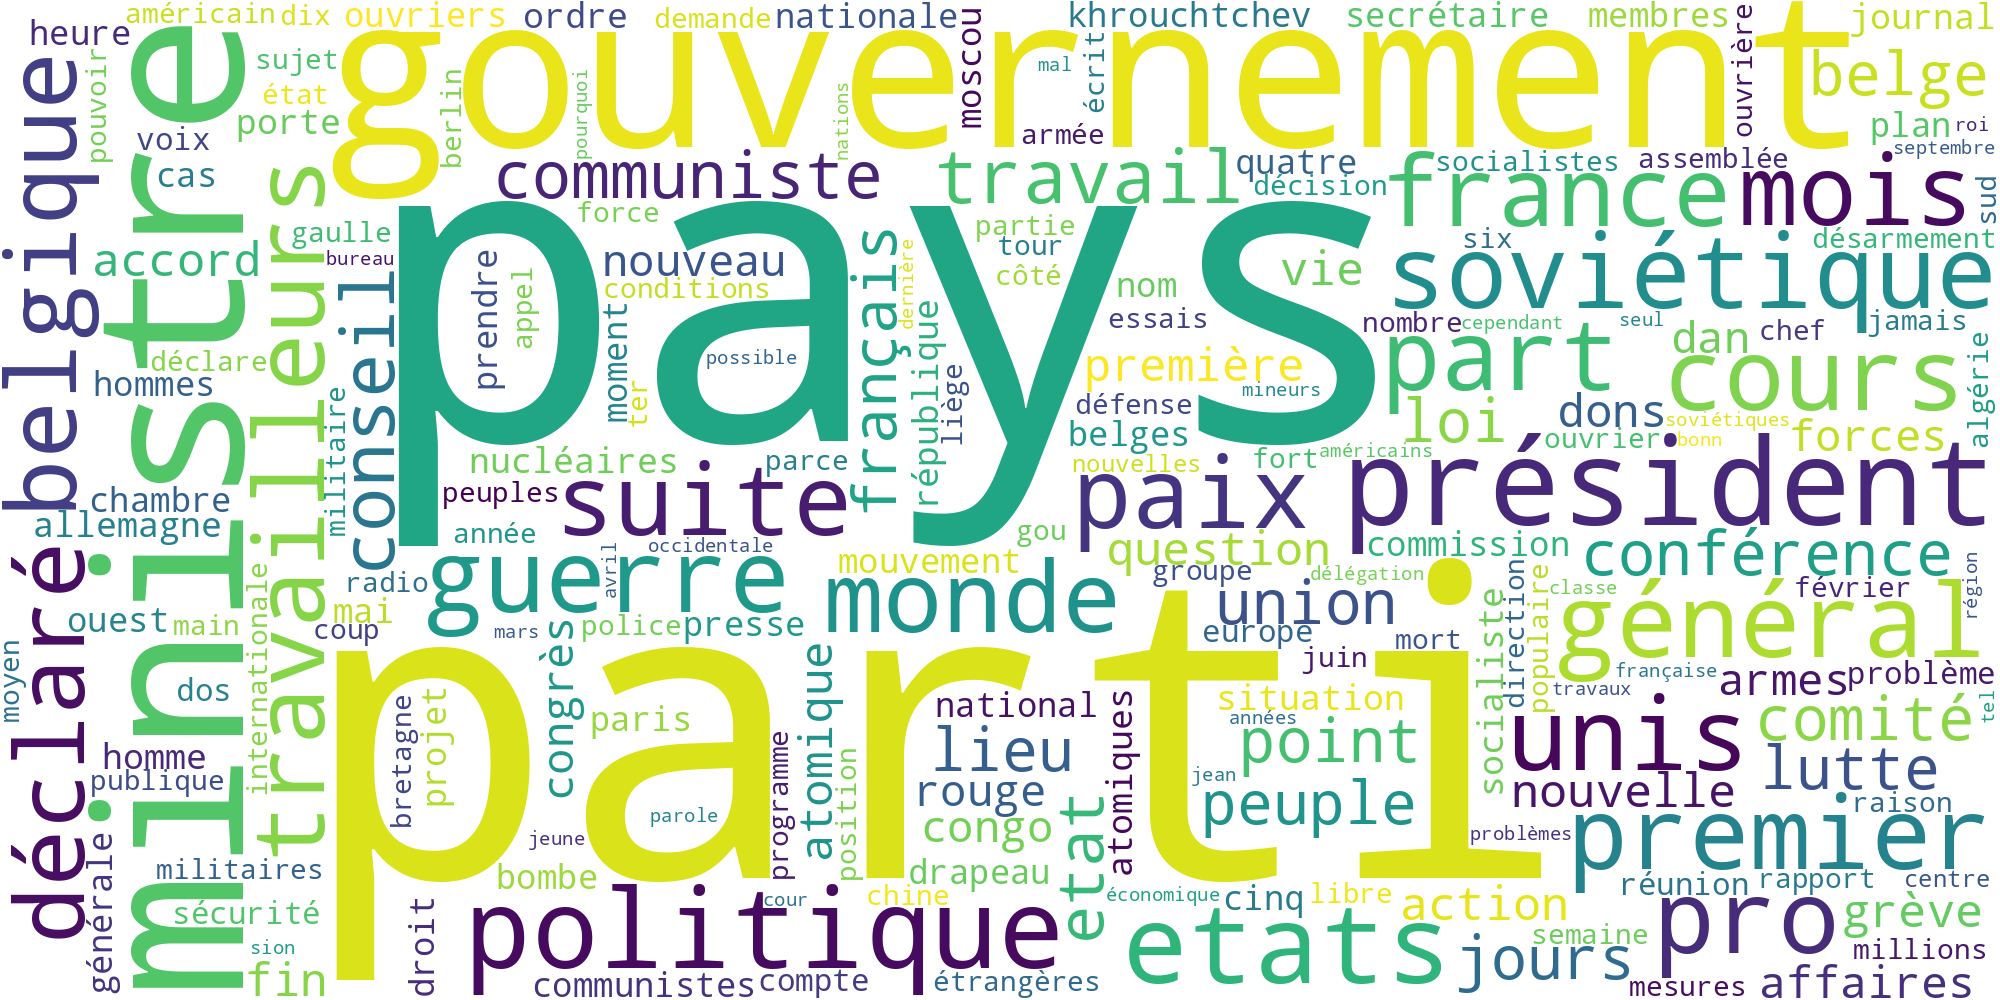

In [47]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies_dr)
cloud.to_file(os.path.join(output_path, f"wordcloud_dr.png"))
Image(filename=os.path.join(output_path, f"wordcloud_dr.png"))

### Reconnaissance des entités nommées avec Spacy

In [48]:
import spacy
from spacy.lang.fr.examples import sentences
!python -m spacy download fr_core_news_md-3.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 20.7 MB/s  0:00:02m0:00:0100:01
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


**All**

In [49]:
nlp = spacy.load('fr_core_news_md')

In [50]:
%%time
# Traiter le texte
n=1000000
doc = nlp(text_clean[:n])

CPU times: user 45.9 s, sys: 1.61 s, total: 47.5 s
Wall time: 47.7 s


In [51]:
# Compter les entités
people = defaultdict(int)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1

In [52]:
# Compter les entités
places = defaultdict(int)
for ent in doc.ents:
    if ent.label_ in ["LOC", "GPE", "FAC"] and len(ent.text) > 3:
        places[ent.text] += 1

In [53]:
# Compter les entités
org = defaultdict(int)
for ent in doc.ents:
    if ent.label_ == "ORG" and len(ent.text) > 3:
        org[ent.text] += 1

In [54]:
# Trier et imprimer

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)

for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

général gaulle apparait 31 fois dans le corpus
dulles apparait 19 fois dans le corpus
pierre jaccoud apparait 19 fois dans le corpus
washington apparait 14 fois dans le corpus
eisenhower apparait 13 fois dans le corpus
nasser apparait 10 fois dans le corpus
fred apparait 10 fois dans le corpus
bach apparait 9 fois dans le corpus
truman apparait 9 fois dans le corpus
acker apparait 9 fois dans le corpus
roosevelt apparait 8 fois dans le corpus
kennedy apparait 8 fois dans le corpus
stimson apparait 8 fois dans le corpus
khrouchtchev apparait 8 fois dans le corpus
henri apparait 7 fois dans le corpus
churchill apparait 7 fois dans le corpus
brahms apparait 7 fois dans le corpus
edouard herriot apparait 6 fois dans le corpus
chamoun apparait 6 fois dans le corpus
léonard vinci apparait 6 fois dans le corpus
maréchal tito apparait 6 fois dans le corpus
liban apparait 6 fois dans le corpus
auguste apparait 6 fois dans le corpus
andré zumbach apparait 6 fois dans le corpus
floriot apparait 6

In [55]:
# Trier et imprimer

sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)

for places, freq in sorted_places[:50]:
    print(f"{places} apparait {freq} fois dans le corpus")

france apparait 83 fois dans le corpus
paris apparait 82 fois dans le corpus
europe apparait 64 fois dans le corpus
londres apparait 51 fois dans le corpus
belgique apparait 49 fois dans le corpus
moscou apparait 45 fois dans le corpus
new york apparait 42 fois dans le corpus
allemagne apparait 39 fois dans le corpus
genève apparait 39 fois dans le corpus
washington apparait 31 fois dans le corpus
angleterre apparait 30 fois dans le corpus
liège apparait 28 fois dans le corpus
rome apparait 26 fois dans le corpus
japon apparait 25 fois dans le corpus
afrique apparait 22 fois dans le corpus
algérie apparait 21 fois dans le corpus
jaccoud apparait 19 fois dans le corpus
bretagne apparait 18 fois dans le corpus
chypre apparait 15 fois dans le corpus
alger apparait 14 fois dans le corpus
luxembourg apparait 12 fois dans le corpus
israël apparait 12 fois dans le corpus
russie apparait 12 fois dans le corpus
ostende apparait 11 fois dans le corpus
inde apparait 10 fois dans le corpus
bruges 

In [56]:
# Trier et imprimer

sorted_org = sorted(org.items(), key=lambda kv: kv[1], reverse=True)

for org, freq in sorted_org[:50]:
    print(f"{org} apparait {freq} fois dans le corpus")

yougoslavie apparait 11 fois dans le corpus
moscou apparait 5 fois dans le corpus
europe apparait 4 fois dans le corpus
jer texas apparait 4 fois dans le corpus
urss apparait 4 fois dans le corpus
gaitskell apparait 3 fois dans le corpus
congo belge ruanda apparait 3 fois dans le corpus
daily telegraph apparait 2 fois dans le corpus
berkeley apparait 2 fois dans le corpus
europe unie apparait 2 fois dans le corpus
france allemagne apparait 2 fois dans le corpus
tunis paris apparait 2 fois dans le corpus
congo apparait 2 fois dans le corpus
montoyer apparait 2 fois dans le corpus
union soviétique apparait 2 fois dans le corpus
congo belge apparait 2 fois dans le corpus
miss botha apparait 1 fois dans le corpus
direction département liebaert apparait 1 fois dans le corpus
dia gnostic apparait 1 fois dans le corpus
navy apparait 1 fois dans le corpus
nieuwe gids apparait 1 fois dans le corpus
université paris conférence apparait 1 fois dans le corpus
legrand apparait 1 fois dans le corpus

**DR**

In [57]:
%%time
# Traiter le texte
n=1000000
doc_dr = nlp(text_clean_jb1051[:n])

CPU times: user 40.3 s, sys: 1.72 s, total: 42 s
Wall time: 42 s


In [58]:
# Compter les entités
people_dr = defaultdict(int)
for ent in doc_dr.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people_dr[ent.text] += 1

In [59]:
# Compter les entités
places_dr = defaultdict(int)
for ent in doc_dr.ents:
    if ent.label_ in ["LOC", "GPE", "FAC"] and len(ent.text) > 3:
        places_dr[ent.text] += 1

In [60]:
# Compter les entités
org_dr = defaultdict(int)
for ent in doc_dr.ents:
    if ent.label_ == "ORG" and len(ent.text) > 3:
        org_dr[ent.text] += 1

In [61]:
# Trier et imprimer

sorted_people_dr = sorted(people_dr.items(), key=lambda kv: kv[1], reverse=True)

for person, freq in sorted_people_dr[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

khrouchtchev apparait 37 fois dans le corpus
gaston moulin apparait 18 fois dans le corpus
eisenhower apparait 15 fois dans le corpus
général gaulle apparait 15 fois dans le corpus
gou vernement apparait 11 fois dans le corpus
henri apparait 10 fois dans le corpus
dulles apparait 10 fois dans le corpus
soviéti apparait 8 fois dans le corpus
kennedy apparait 8 fois dans le corpus
nasser apparait 7 fois dans le corpus
chamoun apparait 6 fois dans le corpus
acker apparait 6 fois dans le corpus
debré apparait 6 fois dans le corpus
nehru apparait 6 fois dans le corpus
stevenson apparait 6 fois dans le corpus
julien apparait 6 fois dans le corpus
liege apparait 5 fois dans le corpus
georges glineur apparait 5 fois dans le corpus
prin apparait 5 fois dans le corpus
afri apparait 5 fois dans le corpus
washington apparait 5 fois dans le corpus
reau apparait 5 fois dans le corpus
tito apparait 4 fois dans le corpus
brankart apparait 4 fois dans le corpus
selwyn lloyd apparait 4 fois dans le corp

In [62]:
# Trier et imprimer

sorted_places_dr = sorted(places_dr.items(), key=lambda kv: kv[1], reverse=True)

for places, freq in sorted_places_dr[:50]:
    print(f"{places} apparait {freq} fois dans le corpus")

france apparait 70 fois dans le corpus
belgique apparait 55 fois dans le corpus
allemagne apparait 51 fois dans le corpus
europe apparait 46 fois dans le corpus
moscou apparait 43 fois dans le corpus
paris apparait 37 fois dans le corpus
chine apparait 30 fois dans le corpus
liège apparait 24 fois dans le corpus
berlin apparait 24 fois dans le corpus
genève apparait 23 fois dans le corpus
algérie apparait 21 fois dans le corpus
washington apparait 20 fois dans le corpus
afrique apparait 19 fois dans le corpus
londres apparait 17 fois dans le corpus
inde apparait 12 fois dans le corpus
pologne apparait 12 fois dans le corpus
rome apparait 11 fois dans le corpus
bretagne apparait 11 fois dans le corpus
congo apparait 11 fois dans le corpus
fran apparait 11 fois dans le corpus
italie apparait 11 fois dans le corpus
new york apparait 10 fois dans le corpus
alger apparait 10 fois dans le corpus
portugal apparait 10 fois dans le corpus
tunisie apparait 9 fois dans le corpus
egypte apparait 9

In [63]:
# Trier et imprimer

sorted_org_dr = sorted(org_dr.items(), key=lambda kv: kv[1], reverse=True)

for org, freq in sorted_org_dr[:50]:
    print(f"{org} apparait {freq} fois dans le corpus")

urss apparait 34 fois dans le corpus
moscou apparait 5 fois dans le corpus
yougoslavie apparait 5 fois dans le corpus
europe apparait 5 fois dans le corpus
union soviétique apparait 4 fois dans le corpus
cockerill apparait 3 fois dans le corpus
stockholm désarmement apparait 3 fois dans le corpus
parti communiste belgique apparait 3 fois dans le corpus
mem bres apparait 3 fois dans le corpus
france presse apparait 2 fois dans le corpus
allemagne fédérale apparait 2 fois dans le corpus
miss apparait 2 fois dans le corpus
parti socialiste unifié allemagne apparait 2 fois dans le corpus
répu apparait 2 fois dans le corpus
foit apparait 2 fois dans le corpus
conférence genève apparait 2 fois dans le corpus
allema gne occidentale apparait 2 fois dans le corpus
mands apparait 2 fois dans le corpus
allema gne apparait 2 fois dans le corpus
acec apparait 2 fois dans le corpus
arrê apparait 2 fois dans le corpus
inten tion apparait 2 fois dans le corpus
france belgique apparait 2 fois dans le c

### Analyse de sentiment

In [64]:
# Imports
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [65]:
# Creation d'une fonction get sentiment
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity_perc}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")
    return {
        "Polarité": polarity_str,
        "Subjectivité": subjectivity_str
    }

In [ ]:
#raw
print(type(all_list)) #list
print(type(all_list_jb1051)) #list

print(type(text_all)) #str
print(type(text_all_jb1051)) #str

#clean
print(type(all_clean)) #list
print(type(all_clean_jb1051)) #list

print(type(text_clean)) #str
print(type(text_clean_jb1051)) #str


<class 'list'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'list'>
<class 'str'>
<class 'str'>


In [ ]:
all_list = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [86]:
sentences_ls = [
    "Peut-on concevoir qu'au XX* siècle à l'âge des fusées spatiales et des bombes atomiques, U existe encore, dans notre pays, des communes totalement privées deréseau de distribution d’eau potable ?",
    "Le Strategie Air Command a annoncé qu’il n’y avait pas de risques d’explosion atomique et qu’il n’était pas nécessaire de faire évacuer la population.",
    "A côté d’événements ainsi localisés, l’année 1957 aura encore été marquée par des faits mondiaux de grande importance en trois - domaines : le progrès scientifique, le renforcement de la puissance militaire atomique et d’incessantes négociations en vue du désarmement...",
    "L’année 1957 aura été ponctuée d’explosions atomiques expéri- • mentales multipliées aux Etats- Unis et en Russie; la Grande- Bretagne s’est jointe à cette com-i pétition pour la première fois le 20 juin. Tous les savants du monde et les plus grandes voix mo- ra.es ont aussi attiré avec anxiété l’attention sur les dangers de ces explosions, et la Belgique a pris aux Nations Unies l’initiative d’une campagne d’avertissement sur les risques des expériences et a fortiori, l’horreur des destructions que provoquerait une guerre atomique.",
    "Tous les savants du monde et les plus grandes voix mo- ra.es ont aussi attiré avec anxiété l’attention sur les dangers de ces explosions, et la Belgique a pris aux Nations Unies l’initiative d’une campagne d’avertissement sur les risques des expériences et a fortiori, l’horreur des destructions que provoquerait une guerre atomique.",
    "Tandis que l’année 1957 aura marqué le point culminant des découvertes permettant une guerre atomique où il ne sera même plus nécessaire d’envahir ou de surveiller les pays ppur les livrer à une mort généralisée, des efforts réels ont été accomplis pour le désarmement",
    "Pendant la dernière guerre, Winston Churchill avait envisagé de faire interner le physicien français Frédéric Joliot-Curie, dont il connaissait les sympathies pro-soviéti- ques. afin que les Etats-Unis et la Grande-Bretagne restent seuls à partager le secret de la bombe atomique.",
    "L'éventualité d'un armement atomique de la Bundeswehr considérée comme probable",
    "L’affaire de la bombe «A» Pourquoi las Américains ont-ils employé la bombe atomique contre le Japon ?",
    "U est évident que le gouvernement français est fermement résolu à continuer à soulever des obstacles sur lé chemin d'un accord sur la cessation des tests, tout en cherchant à se munir de sa propre bombe atomique le plus tôt possible",
    "En quelque 48 heures, on a annoncé successivement que les Russes avalent procédé à six essais satisfaisants de leurs engins, que les manœuvres de l’infanterie américaine avaient été couronnées de succès après l'explosion d’une bombe atomique deux fois plus forte que celle d’Hiroshima, que de la base du can Canaveral"
]

In [87]:
results_ls = [get_sentiment(s) for s in sentences_ls]

This text is 4% positive and 45% subjective.
This text is 14% negative and 20% subjective.
This text is 1% negative and 24% subjective.
This text is 18% positive and 13% subjective.
This text is 14% positive and 17% subjective.
This text is 21% positive and 31% subjective.
This text is 3% negative and 20% subjective.
This text is neutral and 30% subjective.
This text is 16% negative and 25% subjective.
This text is 17% positive and 19% subjective.
This text is 25% positive and 31% subjective.


In [89]:
df = pd.DataFrame(results_ls) 
print(df)

        Polarité    Subjectivité
0    4% positive  45% subjective
1   14% negative  20% subjective
2    1% negative  24% subjective
3   18% positive  13% subjective
4   14% positive  17% subjective
5   21% positive  31% subjective
6    3% negative  20% subjective
7        neutral  30% subjective
8   16% negative  25% subjective
9   17% positive  19% subjective
10  25% positive  31% subjective


In [90]:
sentences_dr = [
    "L'horreur de la guerre atomique hantait les'jours et les nuits de Andrew et Elsie Marshall. Leurs rêves nocturnes se peuplaient de visions d'apo¬ calypse.",
    "Qu'il s'qgisse de Bombes destinées è raser une cité ou à détruire un grand ouvrage d'art, dans les deux cas, la puissance explosive est assez semblable. D'ailleurs, quel intérêt auroit-pn. de ramener une bombe atomique aux capacités tactiques d'une bombe à explosif chimique ? Pour¬ quoi, pour une même puissance destructive, se lancer dans un* fa¬ brication et un* conservation du matériau fissHe si complexes, en choisissant la bombe atomique de préférence à la bombe ordinaire ?",
    "Nouvelles propositions de l'Union Soviétique pour l'arrêt immédiat des expériences atomiques SCOU, 26 mars (par lélépho- domaines des actes pratiques des no, noir» correspondant gouvernements, rmanent Henri Laurent)",
    "Il est temps de prendre des mesures pratiaues pour ces In¬ terdictions, pour cesser la produc¬ tion des armes atomiques et à hydrogène et pour les exclure des armements des Etats",
    "4 victimes d'Hiroshima font la grève de la faim contre les essais atomiques que la Grande-Bretagneapprouv* un accord va effectuer interdisant les essais atomiques.",
    "Le parti du Congrès indien demande l'arrêt immédiat des essais nucléaires Le parti du Congrès indien (parti de Nehru), invite, dans une résolution, tous les gouverne¬ ments du monde et particulière¬ ment à ceux de s puissances qui détiennent des bombes atomiques à poursuivre les négociations en vue d'un accord sur le désarme¬ ment.",
    "Cette nouvelle explosion d'une bombe atomique au Sahara va de pair avec l'intensification de la guerre coloniale contre le peuple algérien.",
    "Agé de 41 ans, le commandant Eatherly ne s'est jamais remis du choc qu'il avait subi après la guerre lorsque fut connue l'éten¬ due des dégâts et des horreurs causés à Hiroshima, par la pre¬ mière bombe atomique",
    "Spaak tremble de voir condamner sa politique, de voir se conclure un accord sur le désarmement atomique, clé du désarmement général.",
    "Redoublons donc d'efforts, agissons de toutes nos forces dès maintenant pour le maintien de la paix, et préparons ainsi de bonnos perspectives de désarmement.",
    "Les savants japo¬ nais attribuent cette radioactivité accrue à l'explosion de la bombe atomique française au Sahara."
]

In [91]:
results_dr = [get_sentiment(s) for s in sentences_dr]

This text is 25% negative and 10% subjective.
This text is 0% negative and 16% subjective.
This text is 10% positive and 16% subjective.
This text is 15% negative and perfectly objective.
This text is neutral and perfectly objective.
This text is 7% positive and 7% subjective.
This text is 3% positive and 8% subjective.
This text is 60% positive and 30% subjective.
This text is neutral and perfectly objective.
This text is 9% negative and 32% subjective.
This text is 35% positive and 15% subjective.


In [92]:
df = pd.DataFrame(results_dr) 
print(df)

        Polarité         Subjectivité
0   25% negative       10% subjective
1    0% negative       16% subjective
2   10% positive       16% subjective
3   15% negative  perfectly objective
4        neutral  perfectly objective
5    7% positive        7% subjective
6    3% positive        8% subjective
7   60% positive       30% subjective
8        neutral  perfectly objective
9    9% negative       32% subjective
10  35% positive       15% subjective


### Clustering

In [17]:
print(files)

['KB_JB838_1957-04-28_01-00002.txt', 'KB_JB838_1957-03-27_01-00003.txt', 'KB_JB838_1962-05-12_01-00009.txt', 'KB_JB838_1959-10-17_01-00004.txt', 'KB_JB838_1963-09-26_01-00010.txt', 'KB_JB838_1962-07-21_01-00009.txt', 'KB_JB838_1959-10-27_01-00002.txt', 'KB_JB838_1958-01-04_01-00002.txt', 'KB_JB838_1964-09-25_01-00004.txt', 'KB_JB838_1963-01-25_01-00006.txt', 'KB_JB1051_1957-05-31_01-00003.txt', 'KB_JB838_1960-02-25_01-00007.txt', 'KB_JB838_1959-09-12_01-00003.txt', 'KB_JB838_1958-04-20_01-00003.txt', 'KB_JB838_1958-07-08_01-00003.txt', 'KB_JB1051_1957-08-13_01-00004.txt', 'KB_JB838_1958-08-31_01-00003.txt', 'KB_JB838_1964-04-19_01-00002.txt', 'KB_JB838_1958-06-17_01-00003.txt', 'KB_JB1051_1958-06-27_01-00003.txt', 'KB_JB838_1958-03-18_01-00003.txt', 'KB_JB838_1962-12-12_01-00001.txt', 'KB_JB838_1957-07-10_01-00002.txt', 'KB_JB838_1964-09-24_01-00002.txt', 'KB_JB838_1958-09-26_01-00020.txt', 'KB_JB838_1962-04-26_01-00008.txt', 'KB_JB838_1957-03-23_01-00001.txt', 'KB_JB838_1961-06-28_01-

In [18]:
print(type(all))

<class 'builtin_function_or_method'>


#### Vetorisation des documents à l'aide de TF-IDF

In [27]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [28]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [29]:
# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors = vectorizer.fit_transform(all_list)

In [30]:
# Détail de la matrice
tfidf_vectors

<938x3817 sparse matrix of type '<class 'numpy.float64'>'
	with 735977 stored elements in Compressed Sparse Row format>

In [31]:
# Imprimer le vecteur tf-IDF du premier document
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

bruits          0.178596
mineur          0.141830
avril           0.130018
danse           0.114235
navires         0.110383
                  ...   
l'explosion     0.000000
l'exposition    0.000000
cardinal        0.000000
l'histoire      0.000000
lecteur         0.000000
Length: 3817, dtype: float64

In [100]:
# Définir un nombre initial de clusters
N_CLUSTERS = 3
# Testé avec 3,4,5,6

In [101]:
# Instancier le modèle K-Means et ses arguments
km_model = KMeans(n_clusters=N_CLUSTERS)

In [102]:
# Appliquer le clustering à l'aide de la fonction `fit_predict`
clusters = km_model.fit_predict(tfidf_vectors)

In [103]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [104]:
pprint(dict(clustering))

{0: ['KB_JB838_1957-04-28_01-00002.txt',
     'KB_JB838_1962-05-12_01-00009.txt',
     'KB_JB838_1959-10-17_01-00004.txt',
     'KB_JB838_1963-09-26_01-00010.txt',
     'KB_JB838_1962-07-21_01-00009.txt',
     'KB_JB838_1959-10-27_01-00002.txt',
     'KB_JB838_1958-01-04_01-00002.txt',
     'KB_JB838_1964-09-25_01-00004.txt',
     'KB_JB838_1960-02-25_01-00007.txt',
     'KB_JB838_1964-04-19_01-00002.txt',
     'KB_JB838_1962-12-12_01-00001.txt',
     'KB_JB838_1957-07-10_01-00002.txt',
     'KB_JB838_1964-09-24_01-00002.txt',
     'KB_JB838_1958-09-26_01-00020.txt',
     'KB_JB838_1962-04-26_01-00008.txt',
     'KB_JB838_1957-03-23_01-00001.txt',
     'KB_JB838_1961-06-28_01-00012.txt',
     'KB_JB838_1958-01-24_01-00001.txt',
     'KB_JB838_1957-02-17_01-00002.txt',
     'KB_JB838_1962-07-05_01-00007.txt',
     'KB_JB838_1959-12-09_01-00005.txt',
     'KB_JB838_1960-01-19_01-00007.txt',
     'KB_JB838_1957-03-01_01-00022.txt',
     'KB_JB838_1960-08-20_01-00007.txt',
     'KB_JB838_1

In [105]:
# Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
# Cette étape est nécessaire afin de visualiser les documents dans un espace 2D
# https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

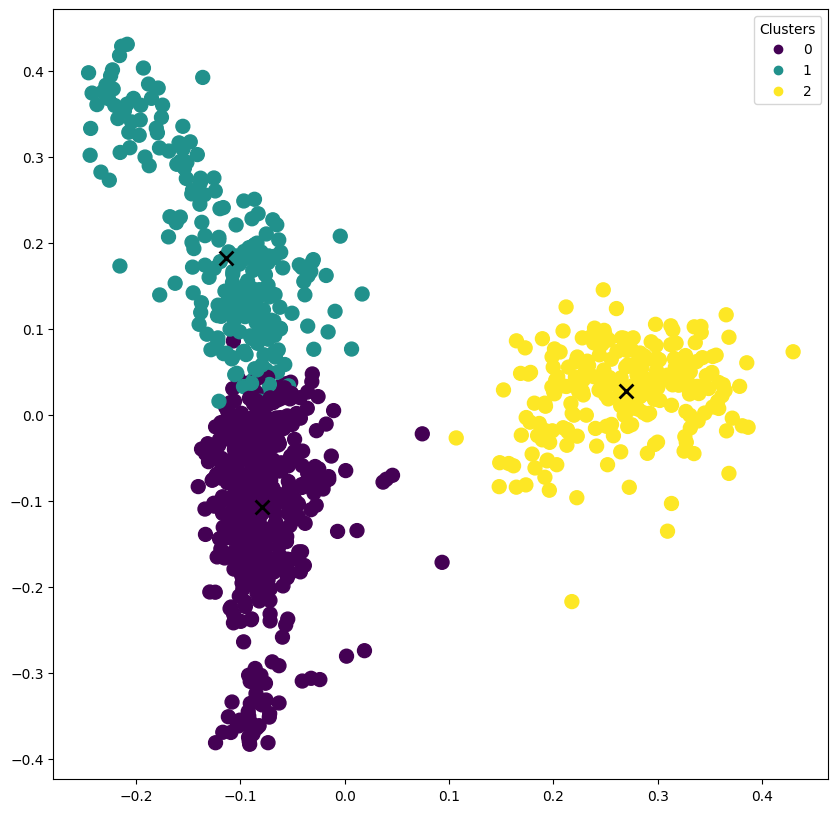

In [106]:
# Générer le plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

plt.savefig(f"./cluster_plot_{N_CLUSTERS}.png", dpi=300, bbox_inches="tight")  # save image